#Trabalho Final de Visão Computacional (2020-1): Classificação de podocitopatia em imagens renais
- Aluno: George Oliveira Barros
- Disciplina: Visão Computacional. PPGI/UnB.
- Dataset: 376 imagens histológicas de glomérulos renais (176 com lesão e 200 sem lesão)
- O dataset não pode ser compartilhado pois faz parte de um conjunto de dados da Fiocruz. Para ser divulgado será necessária a aprovação do comitê de ética da Fundação Osvaldo Cruz (Fiocruz).
- Objetivo: Classificação de imagens de glomérulos renais como imagens "com lesão podocitária" ou "imagens sem lesão podocitária"
- Metodologia: Classificação com diferentes arquiteturas de redes neurais convolucionais e comparação dos resultados das diferentes arquiteturas com transfer learning (Imagenet): Resnet34, Resnet50, Resnet101 e Densenet201.

#LEIA-ME
- Para utilizar os modelos basta carregá-lo e executá-lo com no exemplo a seguir:
- Import a biblioteca da fast ai 
- Os nomes dos modelos salvos foram: resnet34_model_saved e dense201_model_saved
- Você poderá baixar os modelos salvos e algumas imagens que não fizeram parte do dataset no seguinte link: https://drive.google.com/drive/folders/1rQWknzBQY1M02oXD9vYOIrSnH2wVN3D7?usp=sharing
- Aṕos importar o modelo será possível executá-lo nas imagens desconhecidas

In [ ]:
#Importar FAST AI para usar load_learner

In [15]:
modelo = load_learner('/content/drive/MyDrive/Colab Notebooks/resnet34_model_saved')

In [16]:
modelo.predict('/content/drive/MyDrive/dataset-classification/test/com/image0431.tif.jpg')

('com', tensor(0), tensor([9.9984e-01, 1.5993e-04]))

#Dataset e Dependências

In [2]:
#MONTADO AUTOMATICAMENTE QUANDO CARREGO O JUPYTER NOTEBOOK

#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
!pip install fastai --upgrade -q

     |████████████████████████████████| 194kB 8.2MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 


In [4]:
from fastai.vision.all import *

In [5]:
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)

In [6]:
root_dir = '/content/drive/My Drive/'
base_dir = root_dir + 'dataset-classification/tudo'
path=Path(base_dir)

In [7]:
fields = DataBlock(blocks=(ImageBlock, CategoryBlock),
   get_items=get_image_files,
   get_y=parent_label,
   splitter=RandomSplitter(valid_pct=0.25, seed=42),
   item_tfms=RandomResizedCrop(224, min_scale=0.2),
   batch_tfms=aug_transforms(mult=1.0, do_flip=True, flip_vert=True, max_rotate=20.0, min_zoom=1.0, max_zoom=0.3, max_lighting=0.5, max_warp=0.2, p_affine=0.75, p_lighting=0.75, xtra_tfms=None, size=None, mode='bilinear', pad_mode='reflection', align_corners=True, batch=False, min_scale=1.0))

In [8]:
dls = fields.dataloaders(path)

In [9]:
dls.vocab

['com', 'sem']

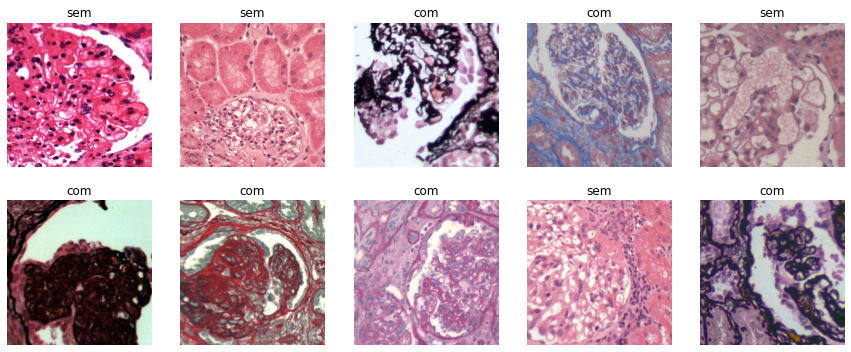

In [10]:
dls.train.show_batch(max_n=10, nrows=2)

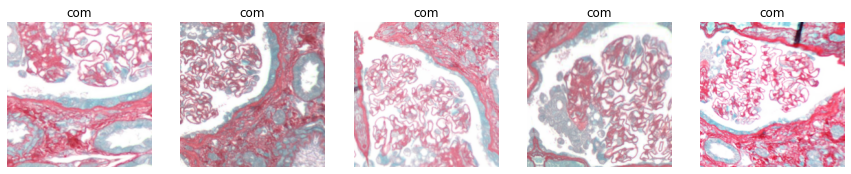

In [11]:
dls.train.show_batch(max_n=5, nrows=1, unique=True)

**Arquiteturas de Redes Rediduais...**

#Resnet34

Iniciando com algumas verificações: fine tunig específico da biblioteca (com apenas uma época pra nova camada adicionada; 

In [11]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.165137,0.579625,0.287234,01:15


epoch,train_loss,valid_loss,error_rate,time
0,0.472589,0.411761,0.159574,00:08
1,0.418559,0.379450,0.127660,00:08


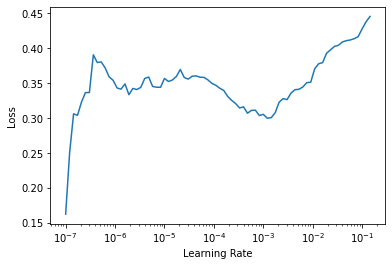

In [12]:
lr_min, lr_steep = learn.lr_find()

In [13]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.20e-04, steepest point: 1.58e-06


In [14]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.258515,0.702073,0.223404,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.597102,0.415402,0.148936,00:08
1,0.521568,0.348489,0.159574,00:08


In [15]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.875611,0.583877,0.159574,00:08
1,0.648948,0.692189,0.127660,00:08
2,0.610259,0.605819,0.117021,00:08


In [16]:
learn.unfreeze()

SuggestedLRs(lr_min=0.0001737800776027143, lr_steep=9.12010818865383e-07)

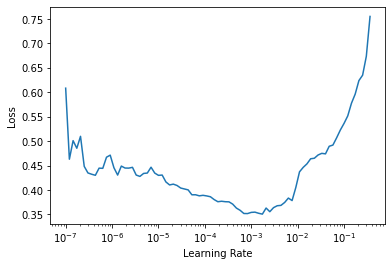

In [17]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(6, lr_max=1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.377180,0.520574,0.095745,00:08
1,0.404933,0.305120,0.095745,00:09
2,0.433650,0.442956,0.127660,00:08
3,0.385593,0.539240,0.148936,00:08
4,0.357240,0.481395,0.148936,00:08
5,0.342765,0.418681,0.138298,00:08


Treino oficial com transfer learning e ajuste de learning rate. 3 épocas na última camada, descongela a rede inteira e depois treno todas as camdas com o learning rate adequado encontrado nas primeiras verificações

In [19]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(4, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(40, 1e-5) #lr_max=slice(1e-5,1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.253789,0.449115,0.138298,00:08
1,0.865187,1.218201,0.234043,00:08
2,0.662576,0.757397,0.159574,00:08
3,0.605332,0.608730,0.138298,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.437340,0.573776,0.148936,00:08
1,0.458801,0.554306,0.127660,00:08
2,0.497936,0.551088,0.127660,00:08
3,0.466313,0.561054,0.138298,00:08
4,0.453921,0.552405,0.138298,00:08
5,0.436610,0.522012,0.138298,00:08
6,0.439414,0.481871,0.127660,00:08
7,0.433743,0.448445,0.117021,00:08
8,0.416097,0.413025,0.117021,00:08
9,0.390981,0.391312,0.106383,00:08


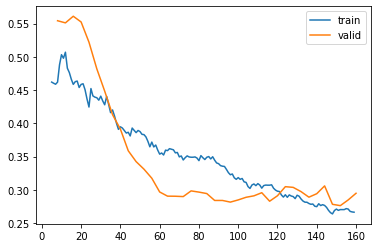

In [20]:
learn.recorder.plot_loss()

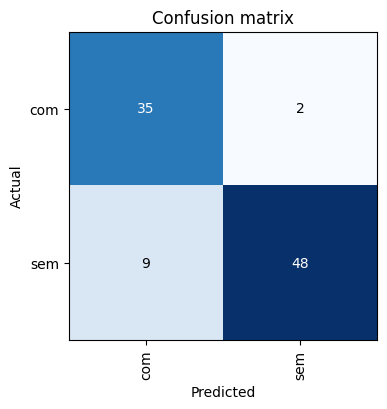

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(dpi=100) #interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

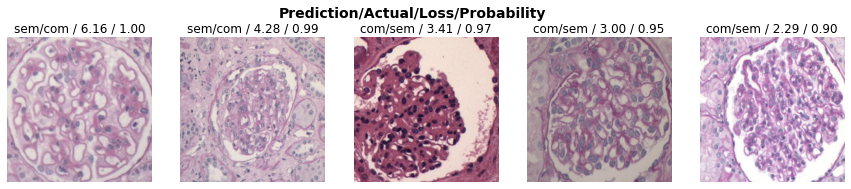

In [22]:
interp.plot_top_losses(5, nrows=1)

In [23]:
interp.print_classification_report()

              precision    recall  f1-score   support

         com       0.80      0.95      0.86        37
         sem       0.96      0.84      0.90        57

    accuracy                           0.88        94
   macro avg       0.88      0.89      0.88        94
weighted avg       0.90      0.88      0.88        94



In [24]:
#learn.export('/content/drive/MyDrive/Colab Notebooks/resnet34_model_saved')

#Resnet50

In [102]:
#carrega a rede resnet50
learn = cnn_learner(dls, resnet50, metrics=error_rate)

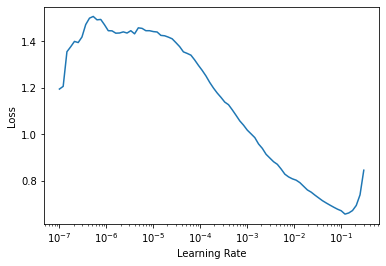

In [103]:
#procura o melhor lr pra treinar a última camada (nova adicionada)
lr_min, lr_steep = learn.lr_find()

In [104]:
#treina a nova camada com o lr adequado encontrado
learn.fit_one_cycle(4,1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,1.389139,1.145036,0.478723,00:08
1,1.230396,0.603010,0.170213,00:08
2,0.984855,0.407025,0.148936,00:08
3,0.872962,0.378041,0.148936,00:08


In [105]:
#descongela as demais camadas
learn.unfreeze()

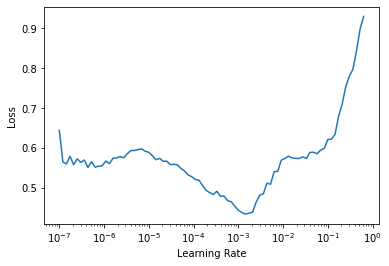

In [106]:
#procura um lr adequado pra treinar a rede inteira
lr_min, lr_steep = learn.lr_find()

In [107]:
learn.fit_one_cycle(20, lr_max=1e-5) #slice(1e-5, 5e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.628598,0.370873,0.148936,00:08
1,0.556295,0.355323,0.138298,00:08
2,0.547004,0.340081,0.117021,00:08
3,0.538812,0.330581,0.117021,00:08
4,0.538614,0.313842,0.106383,00:08
5,0.534373,0.304804,0.106383,00:08
6,0.541422,0.287665,0.106383,00:08
7,0.526287,0.281295,0.106383,00:08
8,0.523099,0.282528,0.095745,00:08
9,0.492223,0.287062,0.095745,00:08


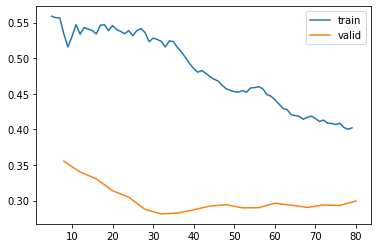

In [108]:
learn.recorder.plot_loss()

In [109]:
interp = ClassificationInterpretation.from_learner(learn)

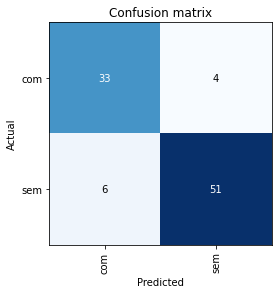

In [110]:
interp.plot_confusion_matrix()

In [111]:
interp.print_classification_report()

              precision    recall  f1-score   support

         com       0.85      0.89      0.87        37
         sem       0.93      0.89      0.91        57

    accuracy                           0.89        94
   macro avg       0.89      0.89      0.89        94
weighted avg       0.90      0.89      0.89        94



In [ ]:
learn.export('/content/drive/MyDrive/Colab Notebooks/resnet50_model_saved')

#Resnet101

In [92]:
learn = cnn_learner(dls, resnet101, metrics=error_rate)

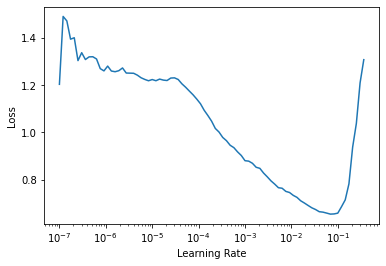

In [93]:
lr_min, lr_steep = learn.lr_find()

In [94]:
learn.fit_one_cycle(5,3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.886598,0.799684,0.297872,00:09
1,0.853937,0.713037,0.138298,00:08
2,0.666399,0.437142,0.085106,00:08
3,0.586835,0.320484,0.063830,00:08
4,0.521926,0.317577,0.053191,00:08


In [95]:
learn.unfreeze()

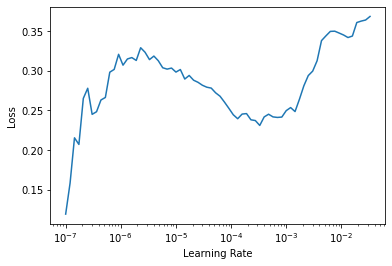

In [96]:
lr_min, lr_steep = learn.lr_find()

In [97]:
learn.fit_one_cycle(20, lr_max=1e-5) #slice(1e-5, 5e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.316229,0.324404,0.053191,00:09
1,0.233132,0.328086,0.074468,00:09
2,0.250246,0.315986,0.053191,00:09
3,0.275759,0.305992,0.074468,00:09
4,0.260885,0.296347,0.063830,00:09
5,0.258488,0.289479,0.063830,00:09
6,0.244359,0.284413,0.053191,00:09
7,0.248791,0.282696,0.042553,00:09
8,0.248412,0.288995,0.053191,00:09
9,0.243115,0.293537,0.053191,00:09


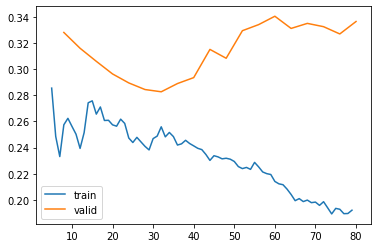

In [98]:
learn.recorder.plot_loss()

In [99]:
interp = ClassificationInterpretation.from_learner(learn)

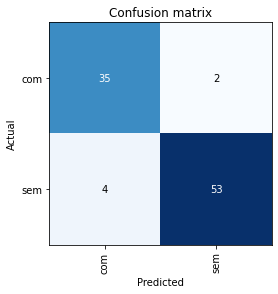

In [100]:
interp.plot_confusion_matrix()

In [101]:
interp.print_classification_report()

              precision    recall  f1-score   support

         com       0.90      0.95      0.92        37
         sem       0.96      0.93      0.95        57

    accuracy                           0.94        94
   macro avg       0.93      0.94      0.93        94
weighted avg       0.94      0.94      0.94        94



In [ ]:
learn.export('/content/drive/MyDrive/Colab Notebooks/resnet101_model_saved')

**Arquitetura de rede Densas...**

#Densenet121

In [112]:
learn = cnn_learner(dls, densenet121, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


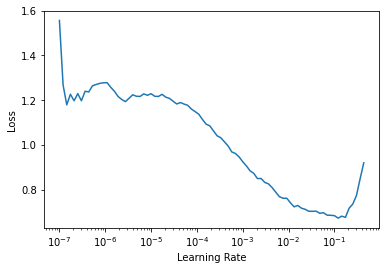

In [113]:
lr_min, lr_steep = learn.lr_find()

In [114]:
learn.fit_one_cycle(5,1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,1.360698,0.706708,0.372340,00:09
1,1.167081,0.591552,0.276596,00:08
2,1.000473,0.480630,0.234043,00:08
3,0.889705,0.436536,0.212766,00:08
4,0.805907,0.440979,0.234043,00:08


In [115]:
#descongela as demais camadas
learn.unfreeze()

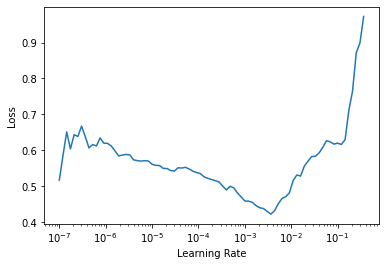

In [116]:
lr_min, lr_steep = learn.lr_find()

In [117]:
learn.fit_one_cycle(20, lr_max=1e-5) #slice(1e-5, 5e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.608311,0.448106,0.212766,00:08
1,0.660862,0.453552,0.223404,00:08
2,0.624567,0.446933,0.223404,00:08
3,0.652936,0.428412,0.202128,00:08
4,0.638144,0.414593,0.191489,00:08
5,0.618250,0.398890,0.170213,00:08
6,0.624043,0.390271,0.180851,00:08
7,0.614217,0.376874,0.170213,00:08
8,0.596549,0.364884,0.159574,00:08
9,0.593343,0.357376,0.159574,00:08


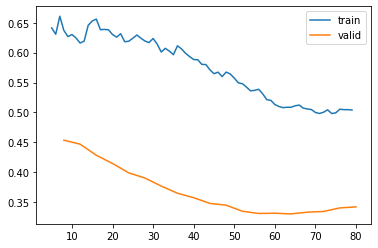

In [118]:
learn.recorder.plot_loss()

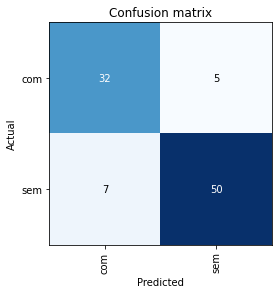

In [119]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [120]:
interp.print_classification_report()

              precision    recall  f1-score   support

         com       0.82      0.86      0.84        37
         sem       0.91      0.88      0.89        57

    accuracy                           0.87        94
   macro avg       0.86      0.87      0.87        94
weighted avg       0.87      0.87      0.87        94



In [ ]:
learn.export('/content/drive/MyDrive/Colab Notebooks/dense121_model_saved')

#Densenet201

In [123]:
learn = cnn_learner(dls, densenet201, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


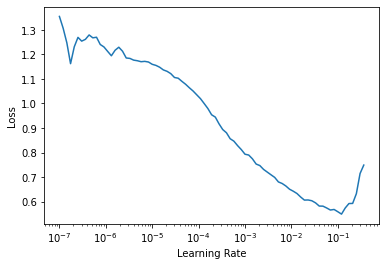

In [124]:
lr_min, lr_steep = learn.lr_find()

In [125]:
learn.fit_one_cycle(5,1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,1.115059,1.939774,0.606383,00:10
1,1.008446,1.011370,0.563830,00:09
2,0.899673,0.533725,0.265957,00:09
3,0.785908,0.396522,0.170213,00:09
4,0.705299,0.353098,0.127660,00:09


In [126]:
learn.unfreeze()

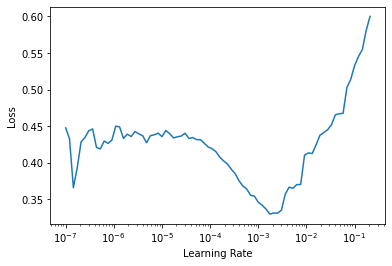

In [127]:
lr_min, lr_steep = learn.lr_find()

In [128]:
learn.fit_one_cycle(20, lr_max=1e-5) #slice(1e-5, 5e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.464031,0.335413,0.127660,00:09
1,0.485213,0.317996,0.117021,00:09
2,0.436323,0.292488,0.106383,00:09
3,0.448934,0.264540,0.085106,00:10
4,0.454282,0.241205,0.095745,00:09
5,0.456058,0.224045,0.095745,00:09
6,0.418445,0.210886,0.095745,00:10
7,0.400713,0.200496,0.095745,00:09
8,0.399839,0.192244,0.095745,00:09
9,0.390246,0.182976,0.085106,00:09


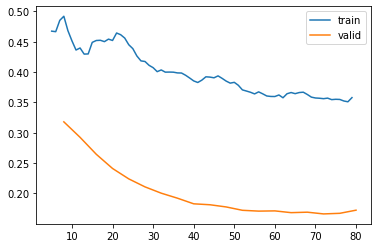

In [129]:
learn.recorder.plot_loss()

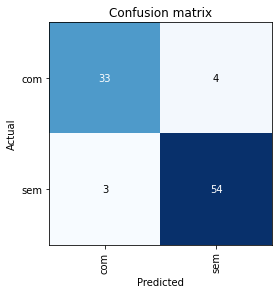

In [130]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [131]:
interp.print_classification_report()

              precision    recall  f1-score   support

         com       0.92      0.89      0.90        37
         sem       0.93      0.95      0.94        57

    accuracy                           0.93        94
   macro avg       0.92      0.92      0.92        94
weighted avg       0.93      0.93      0.93        94



In [132]:
learn.export('/content/drive/MyDrive/Colab Notebooks/dense201_model_saved')